[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ClimateMatchAcademy/course-content/blob/main/tutorials/W2D4_ClimateResponse-Extremes&Variability/W2D4_Tutorial3.ipynb) &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/{ORG}/course-content/main/tutorials/W2D4_ClimateResponse-Extremes&Variability/W2D4_Tutorial3.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# **Tutorial 3: Extreme Value Analysis - the GEV Distribution**

**Week 2, Day 4, Extremes & Vulnerability**

**Content creators:** Matthias Aengenheyster, Joeri Reinders

**Content reviewers:** Younkap Nina Duplex, Sloane Garelick, Zahra Khodakaramimaghsoud, Peter Ohue, Laura Paccini, Jenna Pearson, Agustina Pesce, Derick Temfack, Peizhen Yang, Cheng Zhang, Chi Zhang, Ohad Zivan

**Content editors:** Jenna Pearson, Chi Zhang, Ohad Zivan

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS and Google deepmind

# **Tutorial Objectives**

In the previous tutorial, you used the **empirical method** to determine return values. Another approach involves computing the probability of exceeding a certain threshold using a probability density function fitted to the data. For instance, in Tutorial 1, we used the normal distribution PDF. However, we observed that the normal distribution did not adequately fit our precipitation data. Here we will explore fitting a distribution that is typically more suitable for data with skewed histograms.

By the end of this tutorial, you will gain the following skills:

- Creating a quantile-quantile (QQ) plot to assess the goodness-of-fit between a distribution and the data.
- Fitting a Generalized Extreme Value (GEV) distribution to the data.
- Understanding how the parameters of the GEV distribution influence its behavior.

# **Setup**

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
from scipy.stats import genextreme as gev
import os
import pooch
import tempfile

In [2]:
# @title Figure Settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle")

In [3]:
# @title Video 1: Speaker Introduction
#Tech team will add code to format and display the video

In [4]:
# helper functions

def pooch_load(filelocation=None,filename=None,processor=None):
    shared_location='/home/jovyan/shared/Data/tutorials/W2D4_ClimateResponse-Extremes&Variability' # this is different for each day
    user_temp_cache=tempfile.gettempdir()
    
    if os.path.exists(os.path.join(shared_location,filename)):
        file = os.path.join(shared_location,filename)
    else:
        file = pooch.retrieve(filelocation,known_hash=None,fname=os.path.join(user_temp_cache,filename),processor=processor)

    return file

# **Section 1: Precipitation Data Histogram and Normal Distribution**
Let's repeat our first steps from tutorials 1 and 2: 
1) open the annual maximum daily precipitation record from Germany.
2) create a histogram of the data and plot the normal distribution probability density function.

In [5]:
# download file: 'precipitationGermany_1920-2022.csv'
filename_precipitationGermany='precipitationGermany_1920-2022.csv'
url_precipitationGermany = "https://osf.io/xs7h6/download"
data = pd.read_csv(pooch_load(url_precipitationGermany,filename_precipitationGermany),
                   index_col=0).set_index('years')
data.columns=['precipitation']
precipitation = data.precipitation

Text(0.5, 0, 'Annual Maximum Daily Precipitation \n(mm/day)')

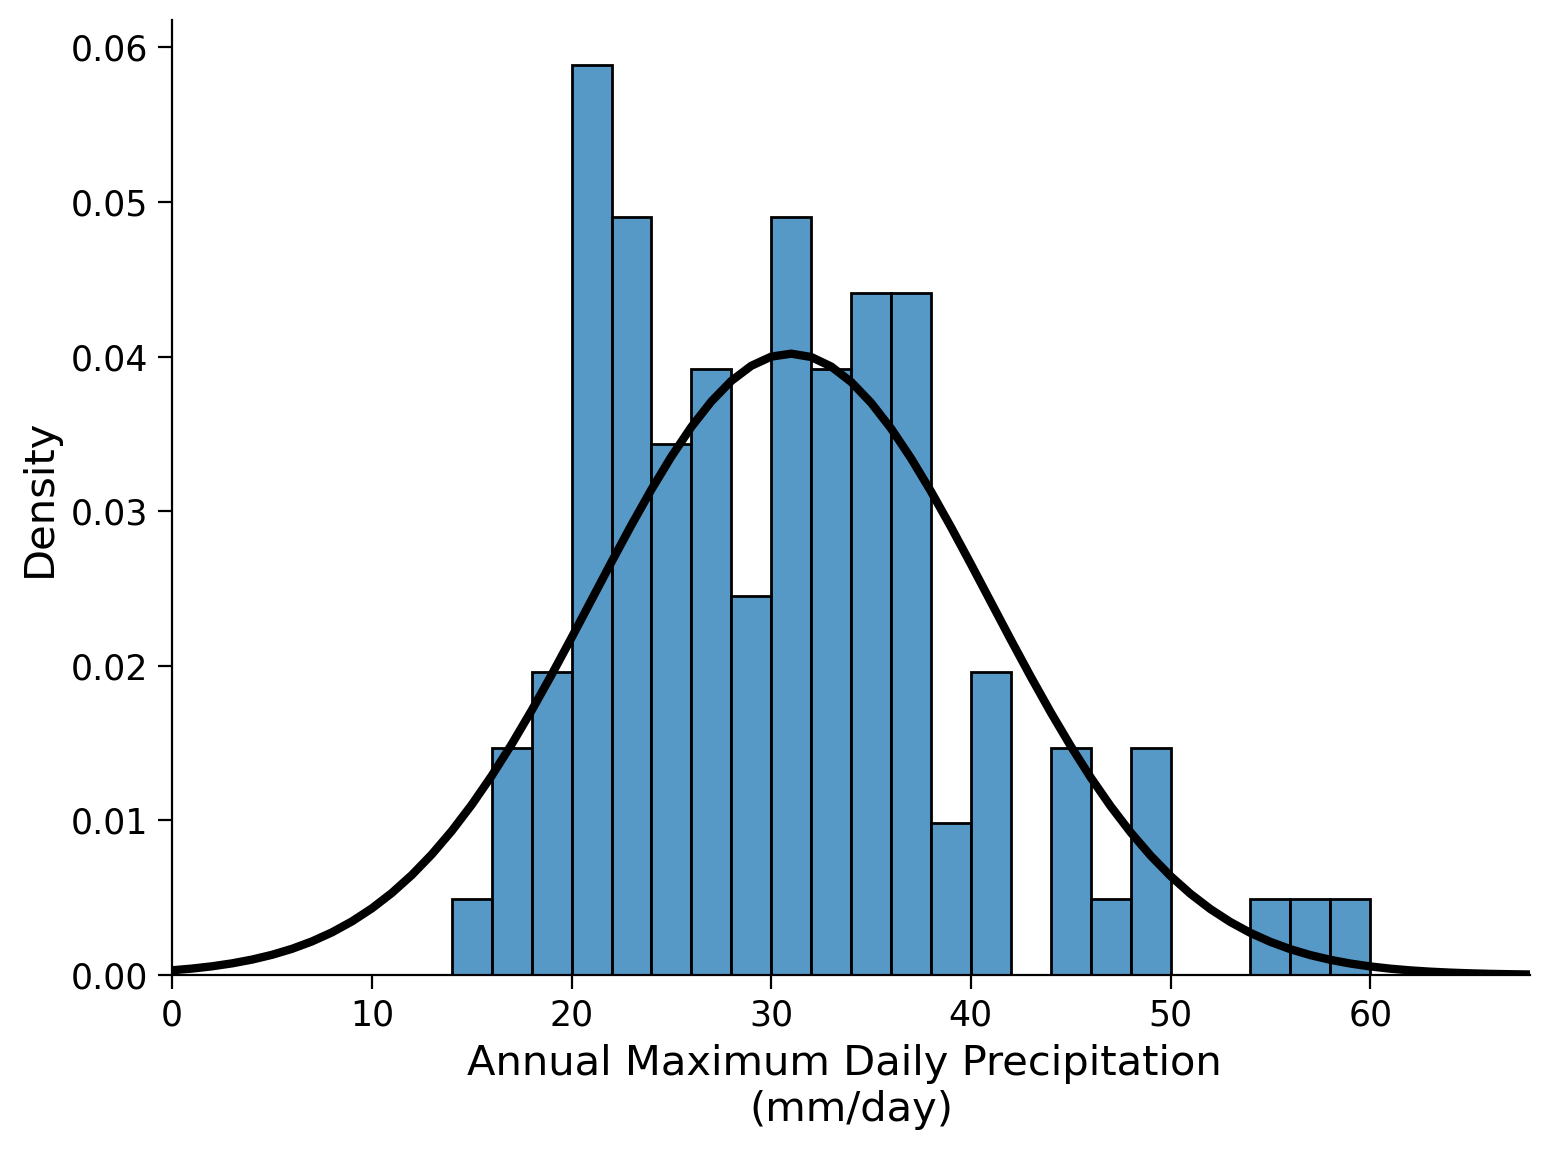

In [6]:
fig,ax=plt.subplots()
x_r100 = np.arange(0,100,1)
bins=np.arange(0,precipitation.max(),2)

# make histogram
sns.histplot(precipitation,bins=bins,stat='density',ax=ax)

# plot PDF
ax.plot(x_r100,stats.norm.pdf(x_r100,precipitation.mean(),precipitation.std()),c='k',lw=3)

ax.set_xlim(bins[0],bins[-1])
ylim = ax.get_ylim()
ax.set_xlabel('Annual Maximum Daily Precipitation \n(mm/day)')

Next, we generate a [quanitile-quantile (QQ) plot](https://en.wikipedia.org/wiki/Q–Q_plot) to assess how well our data aligns with a normal distribution. A QQ plot compares the *actual* [percentiles](https://en.wikipedia.org/wiki/Percentile) of the data to the *expected* percentiles based on a specific distribution, such as a normal distribution in this case. The percentiles are the points in your data below which a certain proportion of your data fall. Here will be using [`norm.ppf()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html#scipy-stats-norm) where 'ppf' stands for percent point function, and returns the quantiles of the normal distribution function (i.e. percentiles). On our precipitation data we will be using [`numpy.quantile()`](https://numpy.org/doc/stable/reference/generated/numpy.quantile.html).

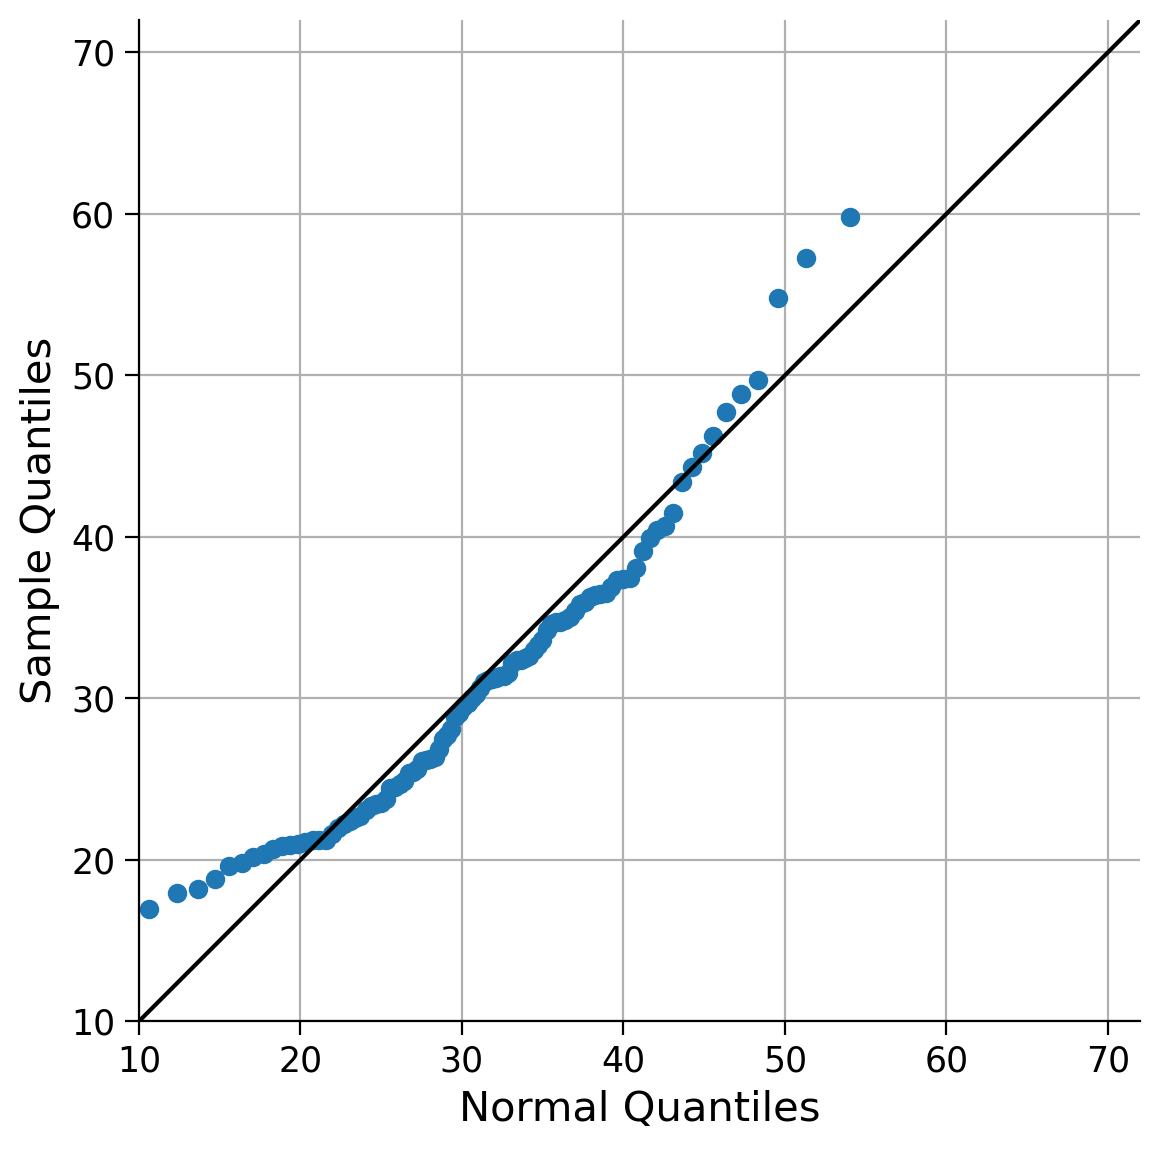

In [7]:
x_r1 = np.linspace(0,1,100)

fig,ax=plt.subplots()


ax.plot(
    stats.norm.ppf(x_r1,precipitation.mean(), precipitation.std()), # quantiles of a normal distribution with the mean and std of our precip data
    np.quantile(precipitation,x_r1),  # quantiles of our precip data
    'o')
ax.plot(x_r100,x_r100,'k')

ax.set_xlim(10,72)
ax.set_ylim(10,72)

ax.set_xlabel('Normal Quantiles')
ax.set_ylabel('Sample Quantiles')

ax.grid(True)
ax.set_aspect('equal')

If the fit was perfect, the quantile comparison would fall on the 1:1 line plotted in black. The stronger the deviations from the 1:1 line, the worse this particular probability density function fits our data. Hopefully, you concur that the current fit could be improved, particularly when it comes to the extreme values (lower and upper quantiles), which appear to be over- and underestimated by the normal distribution model. Therefore, let's explore alternative options, as there are numerous other distributions available. One example is the [General Extreme Value (GEV) distribution](https://en.wikipedia.org/wiki/Generalized_extreme_value_distribution).

The normal distribution is completely defined by two parameters: its mean and standard deviation.
In contrast, the GEV distribution is defined by three parameters: the location, scale, and shape parameters. When the mean of the normal distribution is increased, it shifts the distribution towards higher values, while increasing the standard deviation makes the distribution wider. The normal distribution is symmetrical to its mean as it lacks a parameter that influences its skewness: There is always exactly half of the distribution to the right and left of its mean. This can pose challenges in certain scenarios.

In the GEV distribution, the location and scale parameters behave similarly to the mean and standard deviation in the normal distribution. The shape parameter impacts the tails of the distribution, making them thinner or thicker. As extreme event distributions often exhibit thick tails, they tend to possess slight skewness. Adjusting the shape parameter, therefore, influences the skewness (and kurtosis) of the data.

To estimate the parameters of the GEV distribution, we utilize the [`stats.genextreme()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.genextreme.html#scipy-stats-genextreme) function from the `scipy` package. Here we call this function `gev`. While the normal distribution only requires the mean and standard deviation as parameters, the GEV distribution requires three parameters (location, scale, and shape). These parameters can be estimated from data using by calling `gev.fit()`. Note the second argument to this function given below is optional, it is the starting guess for the shape parameter. It sometimes makes sense to set this to zero as otherwise the fitting algorithm may be unstable and return incorrect values (hint: always check if your results are sensible!).

In [8]:
shape, loc, scale = gev.fit(precipitation.values,0)

In [9]:
shape,loc,scale

(-0.04713587000734158, 26.353581930592185, 7.369405343826601)

Let's generate another histogram of the data and overlay the Generalized Extreme Value (GEV) distribution with the fitted parameters. It's important to note that there are two sign conventions for the shape parameter. You may encounter an application that has it defined the other way around - check the documentation.

Text(0.5, 0, 'Annual Maximum Daily Precipitation \n(mm/day)')

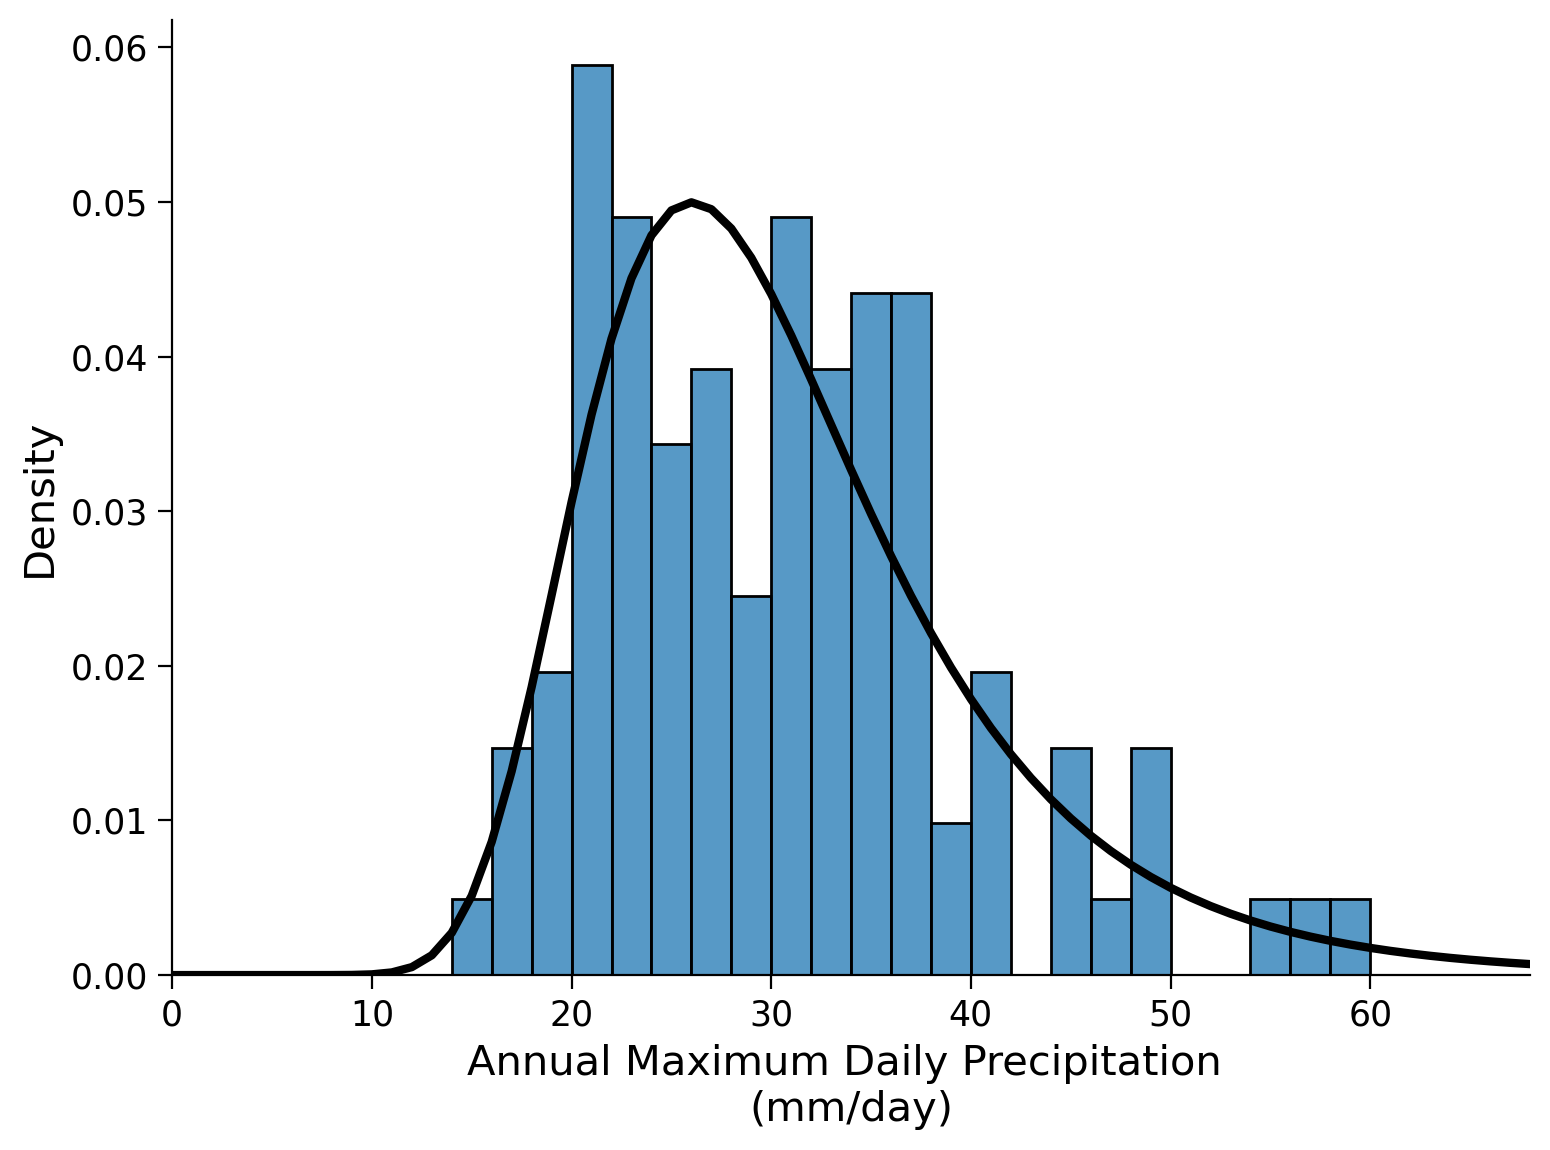

In [10]:
fig,ax=plt.subplots()
# make histogram
sns.histplot(precipitation,bins=bins,stat='density',ax=ax)
ax.set_xlim(bins[0],bins[-1])

# add GEV PDF
x_r80 = np.arange(80)

ax.plot(x_r80,gev.pdf(x_r80, shape, loc=loc, scale=scale),'k',lw=3)
ax.set_xlabel('Annual Maximum Daily Precipitation \n(mm/day)')

And also create a QQ-plot:

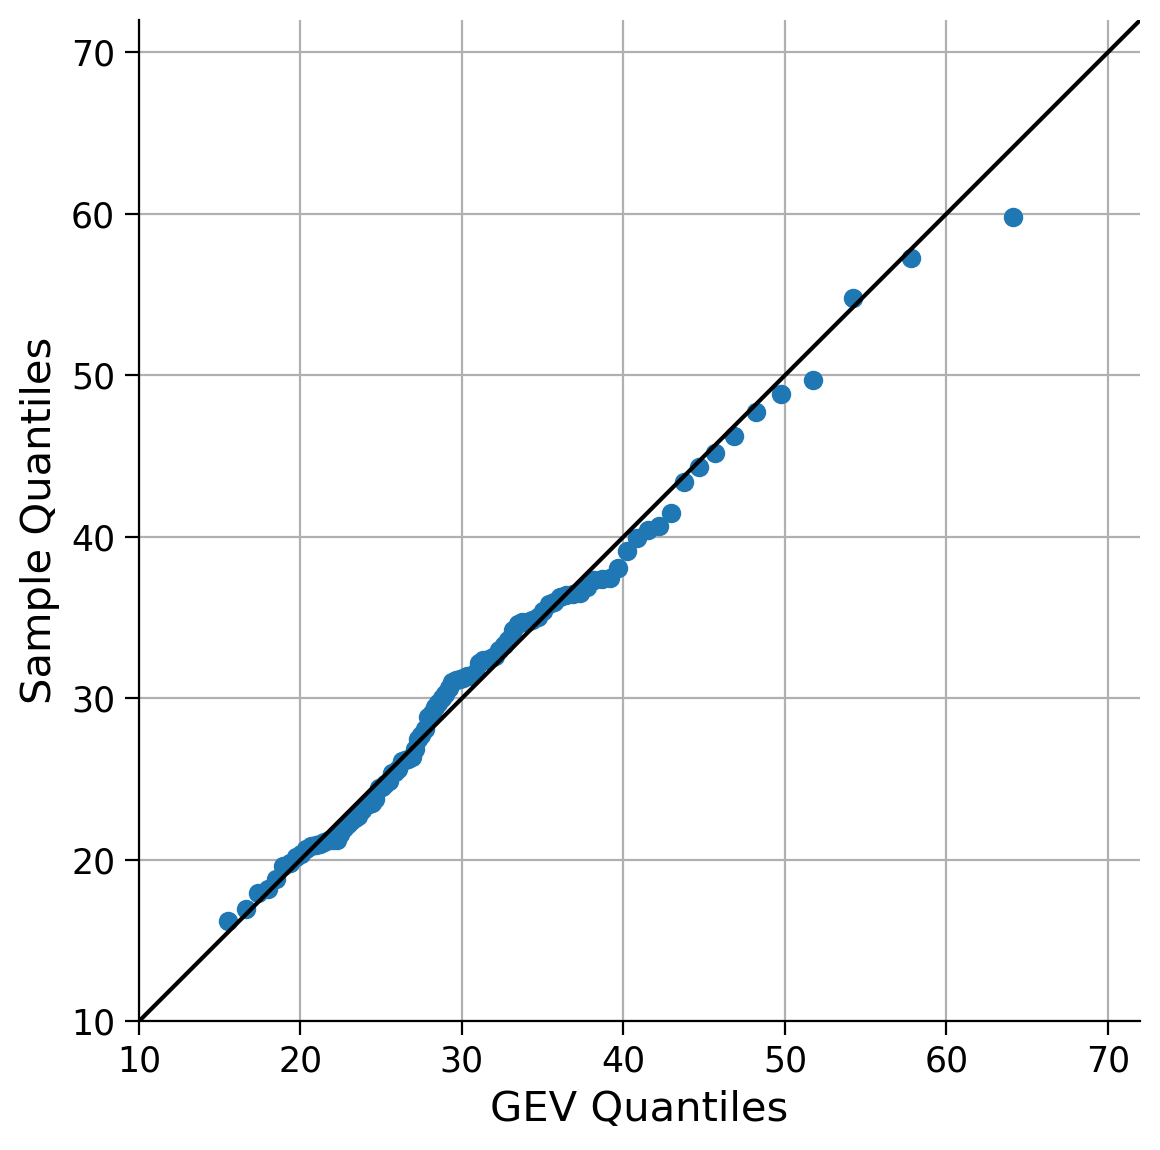

In [11]:
x_r1 = np.linspace(0,1,100)
x_r100 = np.linspace(0,100,100)

fig,ax=plt.subplots()
ax.plot(
    gev.ppf(x_r1, shape, loc=loc, scale=scale), # quantiles of GEV distribution using the parameter estimates from our data
    np.quantile(precipitation,x_r1),'o') # actual quantiles of our data

ax.plot(x_r100,x_r100,'k')

ax.set_xlim(10,72)
ax.set_ylim(10,72)

ax.set_xlabel('GEV Quantiles')
ax.set_ylabel('Sample Quantiles')

ax.grid(True)
ax.set_aspect('equal')

This looks much better! As we exepected, the GEV distribution is a better fit for the data than the Normal distribution given the skewness of the data we observed in tutorial 1.

Now, we will overlay both PDFs (normal and GEV) on a single plot to visualize and compare the differences between them.

Text(0, 0.5, 'Density')

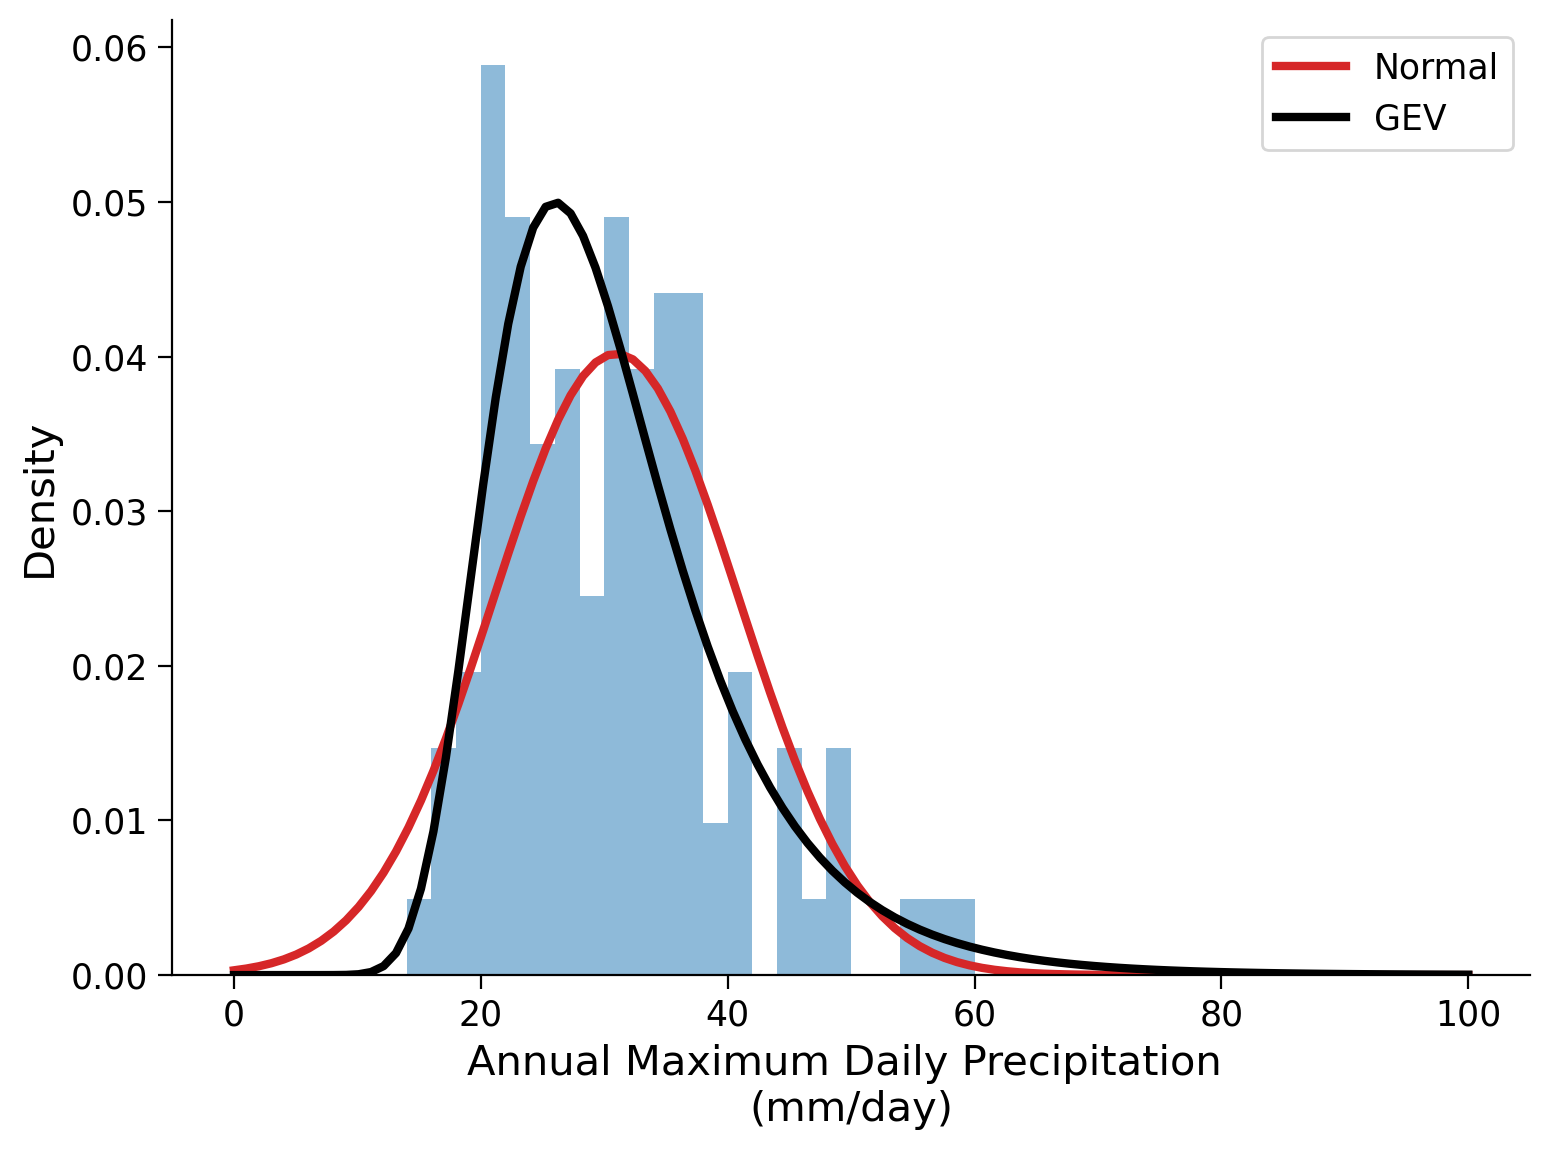

In [12]:
fig,ax=plt.subplots()

sns.histplot(precipitation,bins=bins,stat='density',ax=ax,alpha=0.5,lw=0)

# normal distribution
ax.plot(x_r100,stats.norm.pdf(x_r100,precipitation.mean(),precipitation.std()),c='C3',lw=3,label='Normal')
# GEV distribution
ax.plot(x_r100,gev.pdf(x_r100, shape, loc=loc, scale=scale),c='k',lw=3,label='GEV')
ax.legend()
ax.set_xlabel('Annual Maximum Daily Precipitation \n(mm/day)')
ax.set_ylabel('Density')

How well do the two fitted distributions reflect the observed data and how do they compare to each other? 

## **Coding Exercise 1**

Parameters of the GEV distribution

Play a little with the gev.pdf function to get a better sense of how the parameters affect the shape of the pdf (distribution). Plot the distribution against the
‘x’ sequence and randomly change the parameters. What does each parameter do? 

Create three plots. In each, one of the parameters (location, scale, shape) is varied while the other two are held constant. The parameter values and ranges below may be a useful starting point.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Density')

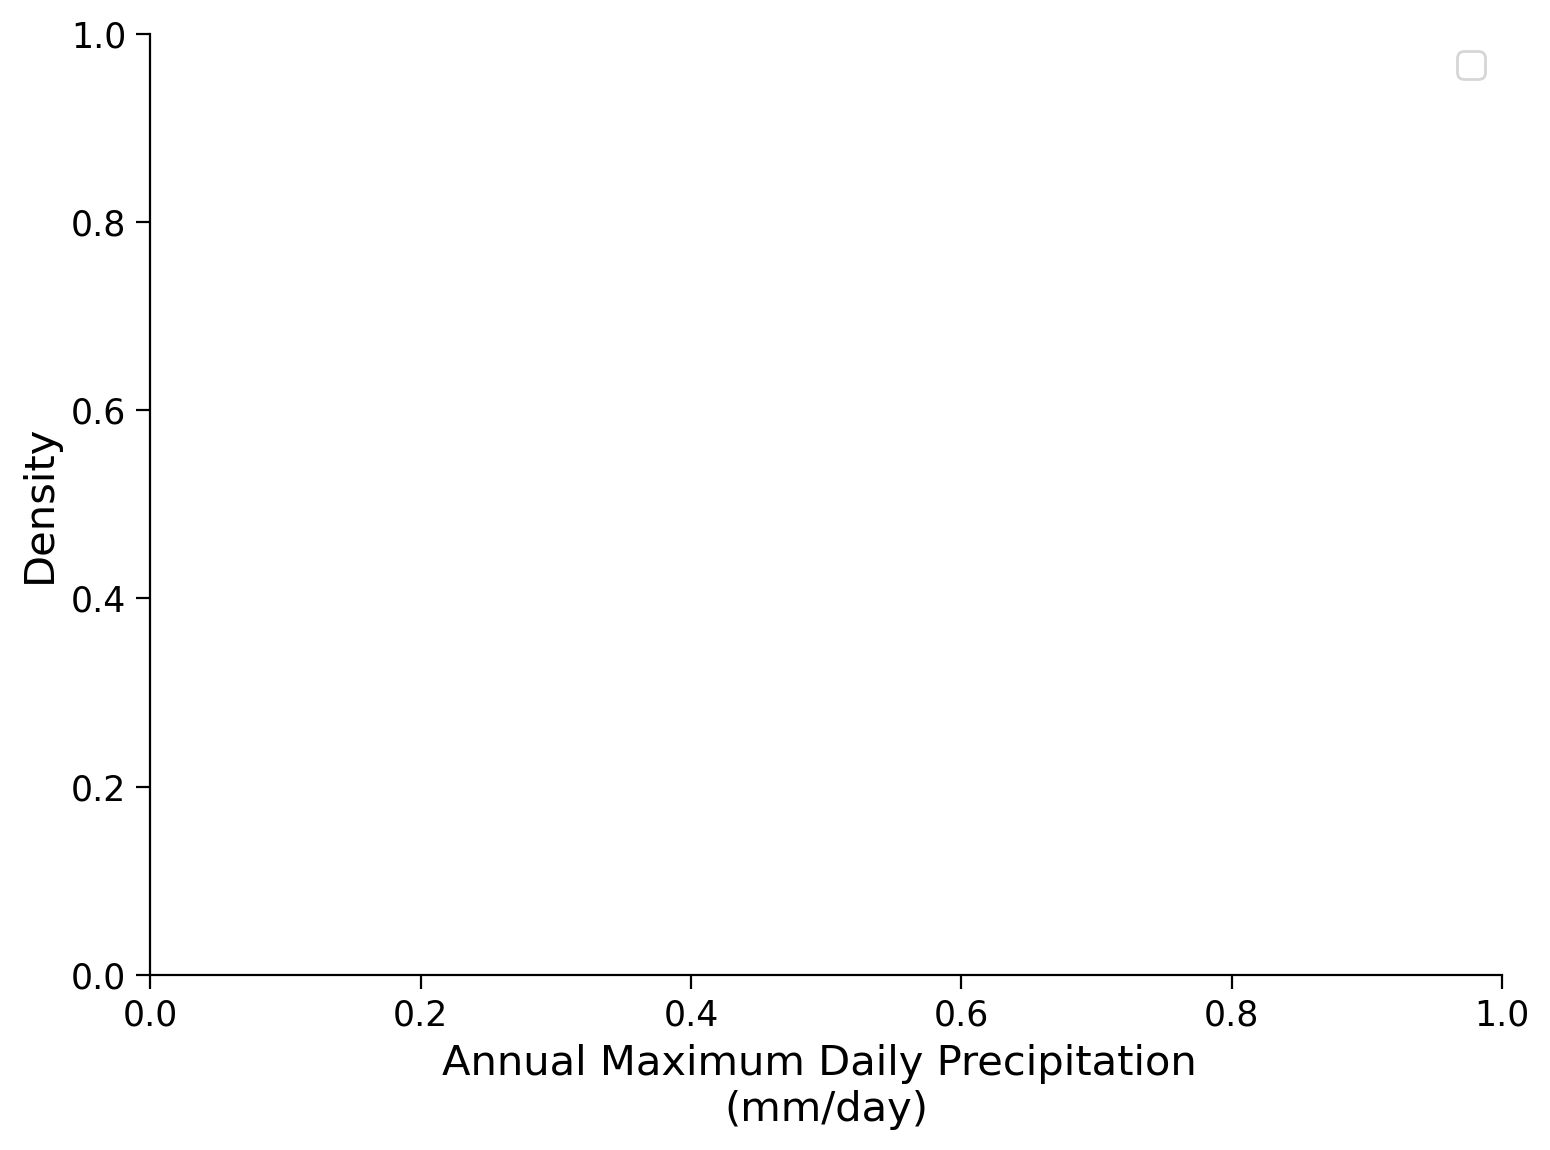

In [13]:
# set range of location values to use
range_loc = np.arange(20,41,4)

# set shape parameter
shape = 0

# set scale parameter
scale = 7

# set x values
x_r80 = np.linspace(0,80,1000)

# setup plots
fig, ax = plt.subplots()

# setup colors to use for lines
colors_loc = plt.cm.coolwarm(np.linspace(0,1,range_loc.size))

# generate pdf for each location value
for idx,loci in enumerate(range_loc):
    ...

# aesthetics
ax.legend()
ax.set_xlabel('Annual Maximum Daily Precipitation \n(mm/day)')
ax.set_ylabel('Density')

Text(0, 0.5, 'Density')

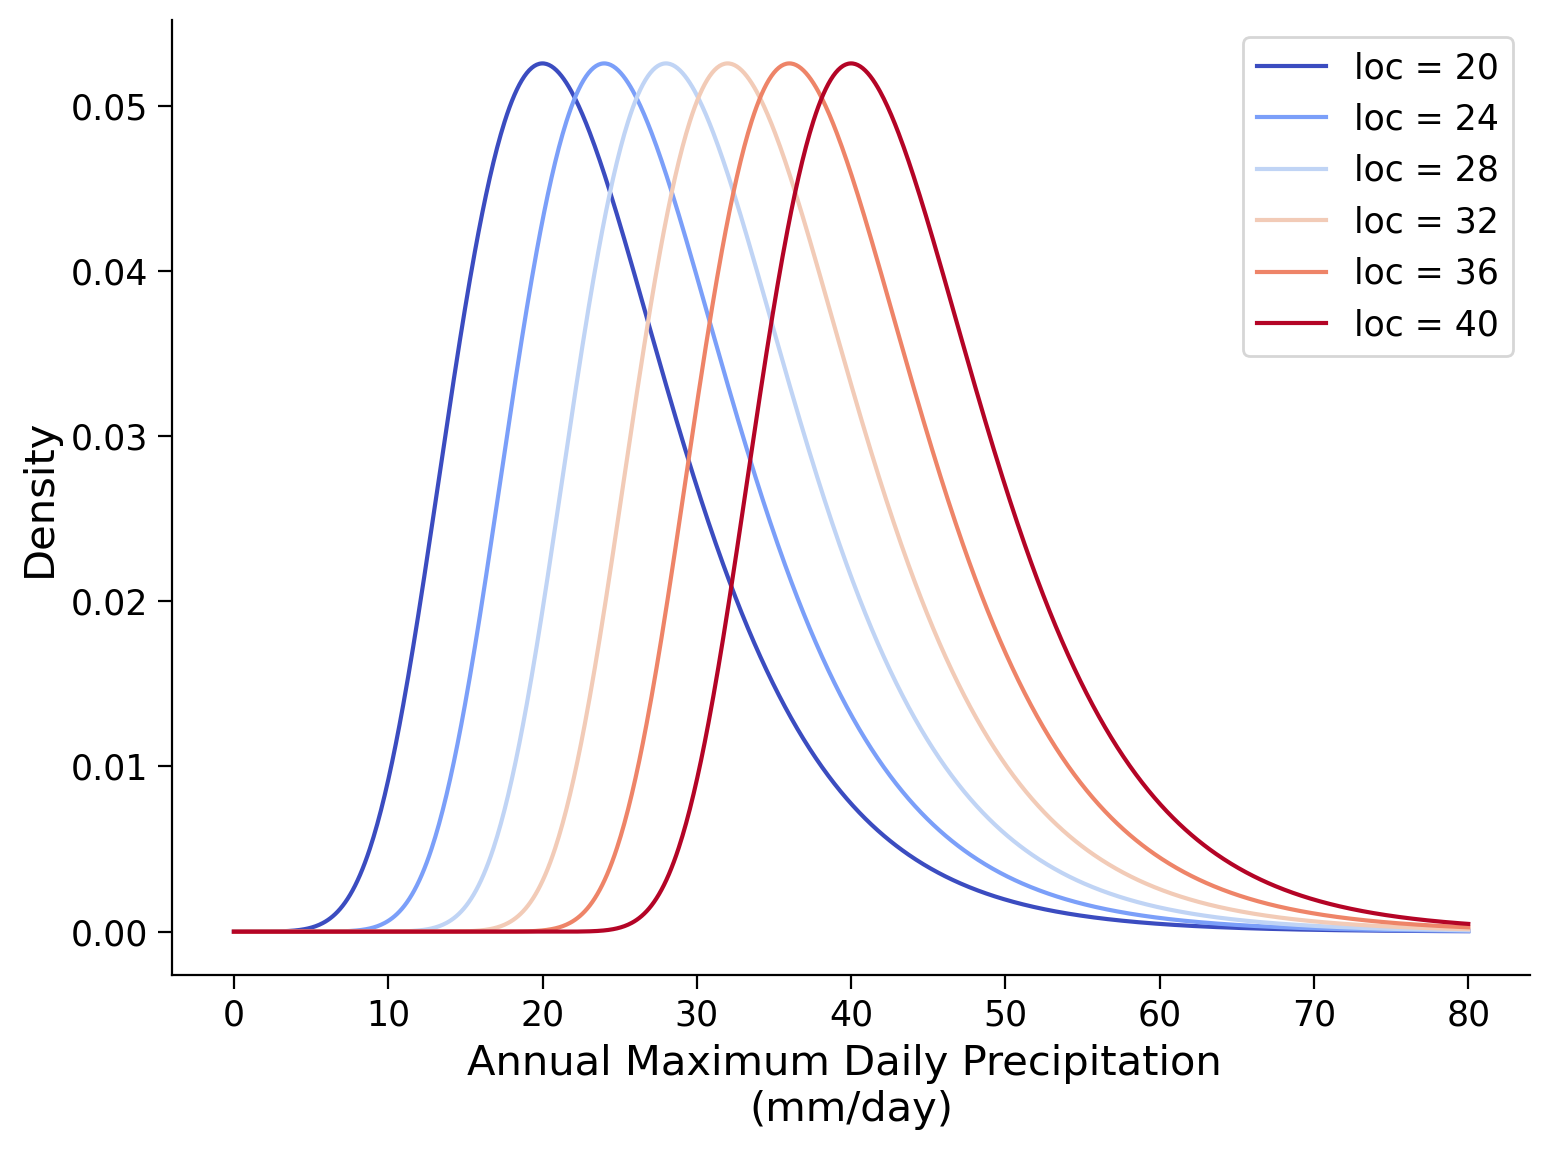

In [14]:
# to_remove solution

# set range of location values to use
range_loc = np.arange(20,41,4)

# set shape parameter
shape = 0

# set scale parameter
scale = 7

# set x values
x_r80 = np.linspace(0,80,1000)

# setup plots
fig, ax = plt.subplots()

# setup colors to use for lines
colors_loc = plt.cm.coolwarm(np.linspace(0,1,range_loc.size))

# generate pdf for each location value
for idx,loci in enumerate(range_loc):
    ax.plot(x_r80,gev.pdf(x_r80, shape, loc=loci, scale=scale),color=colors_loc[idx],label='loc = %i' % loci)

# aesthetics
ax.legend()
ax.set_xlabel('Annual Maximum Daily Precipitation \n(mm/day)')
ax.set_ylabel('Density')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Density')

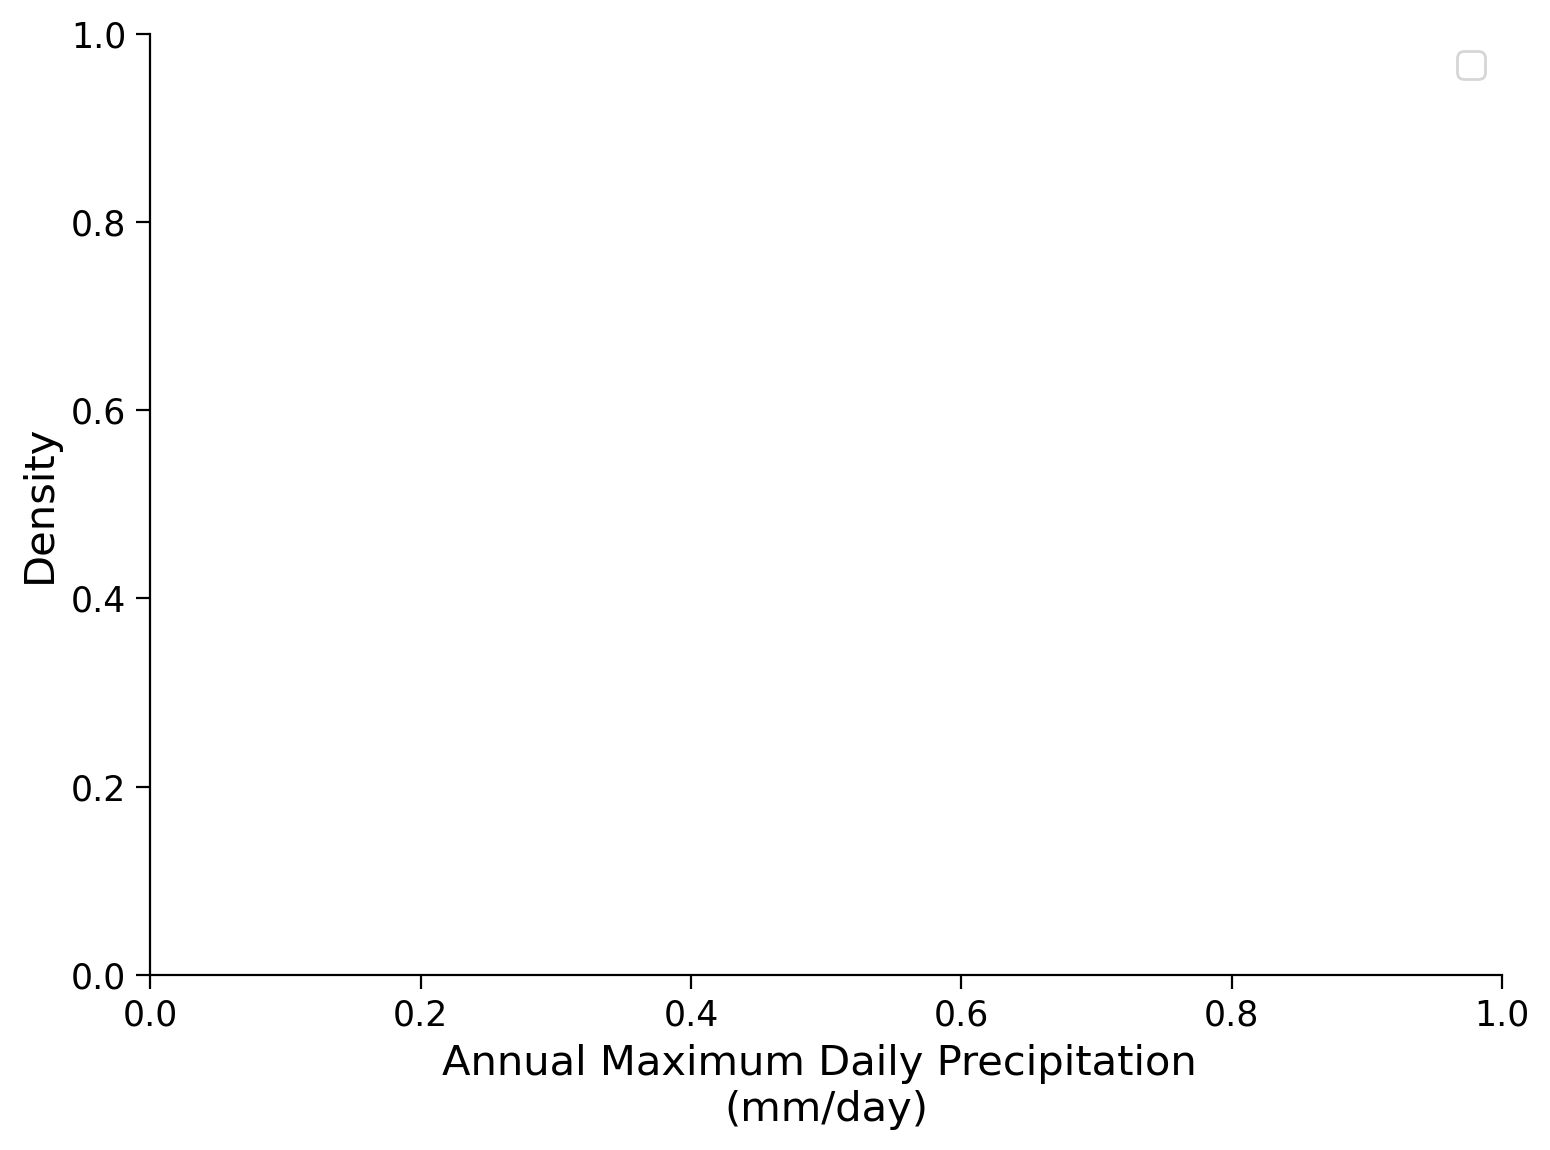

In [ ]:
# set range of scale values to use
range_scale = np.arange(4,11,1)

# set shape parameter
shape = 0

# set location parameter
loc = 26

# setup plots
fig, ax = plt.subplots()

# setup colors to use for lines
colors_scale = plt.cm.coolwarm(np.linspace(0,1,range_scale.size))

# generate pdf for each scale value
for idx,scalei in enumerate(range_scale):
    ...

# aesthetics
ax.legend()
ax.set_xlabel('Annual Maximum Daily Precipitation \n(mm/day)')
ax.set_ylabel('Density')

Text(0, 0.5, 'Density')

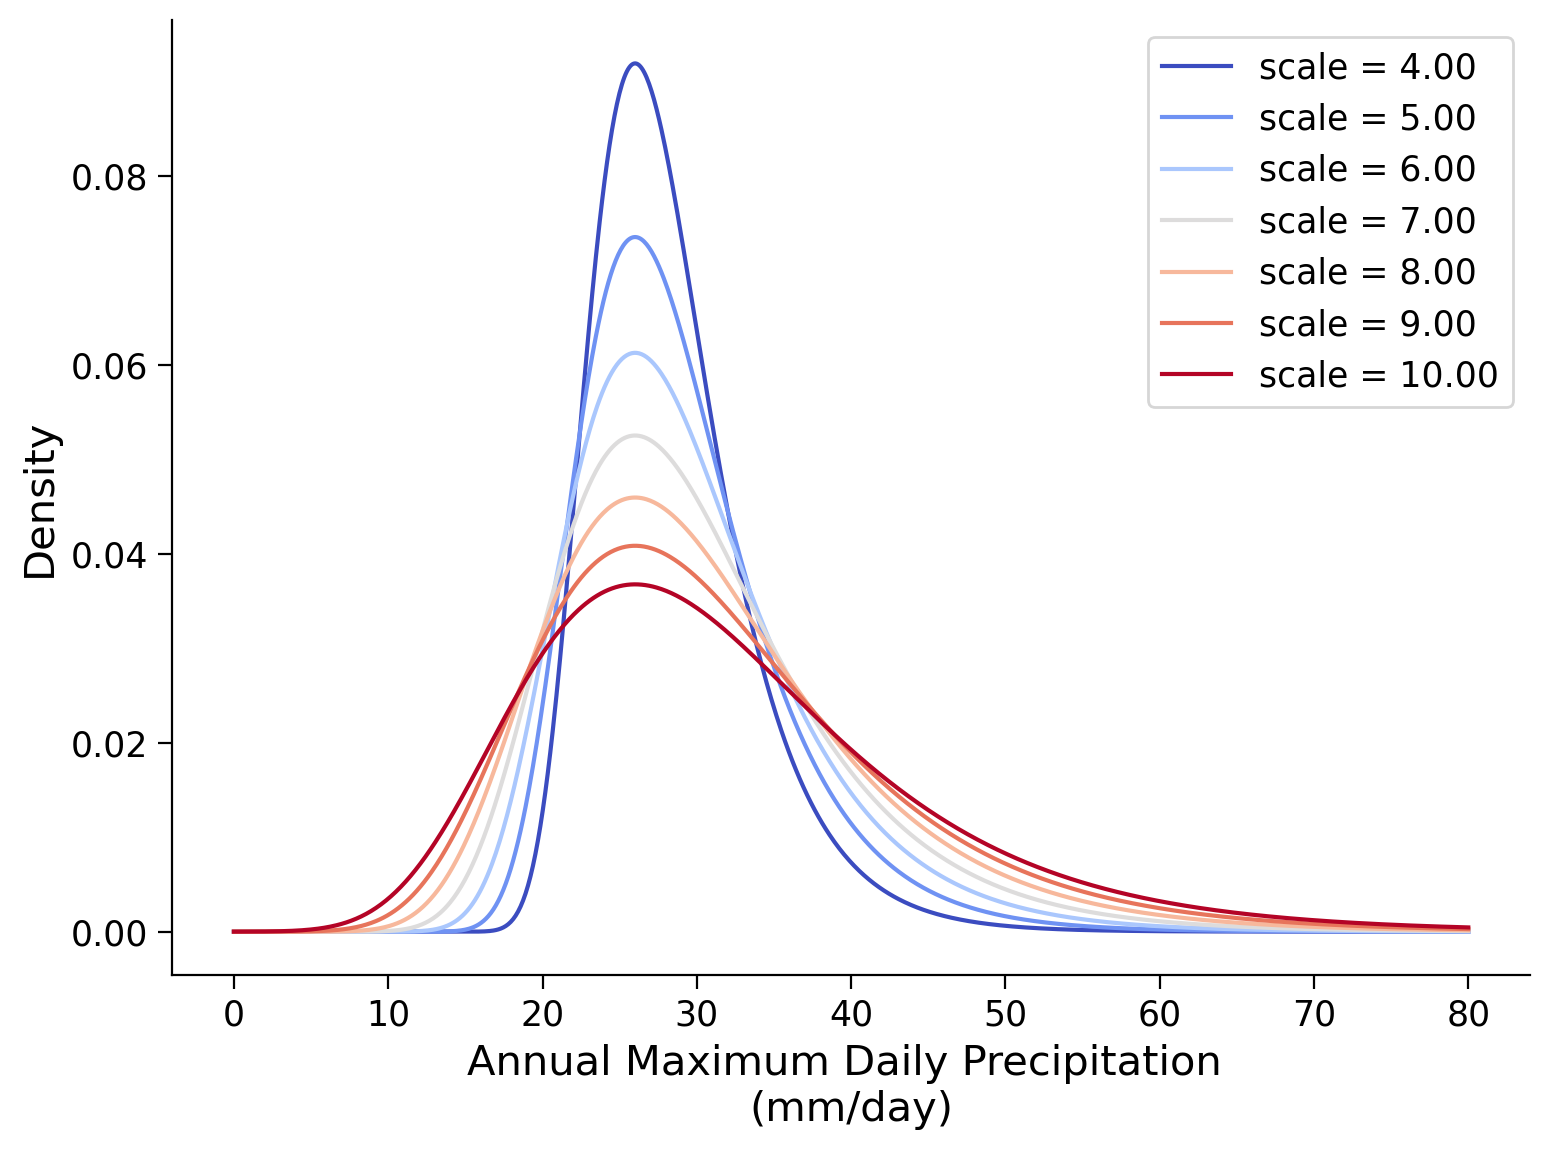

In [15]:
# to_remove solution

# set range of scale values to use
range_scale = np.arange(4,11,1)

# set shape parameter
shape = 0

# set location parameter
loc = 26

# setup plots
fig, ax = plt.subplots()

# setup colors to use for lines
colors_scale = plt.cm.coolwarm(np.linspace(0,1,range_scale.size))

# generate pdf for each scale value
for idx,scalei in enumerate(range_scale):
    ax.plot(x_r80,gev.pdf(x_r80, shape, loc=loc, scale=scalei),color=colors_scale[idx],label='scale = %.2f' % scalei)

# aesthetics
ax.legend()
ax.set_xlabel('Annual Maximum Daily Precipitation \n(mm/day)')
ax.set_ylabel('Density')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Density')

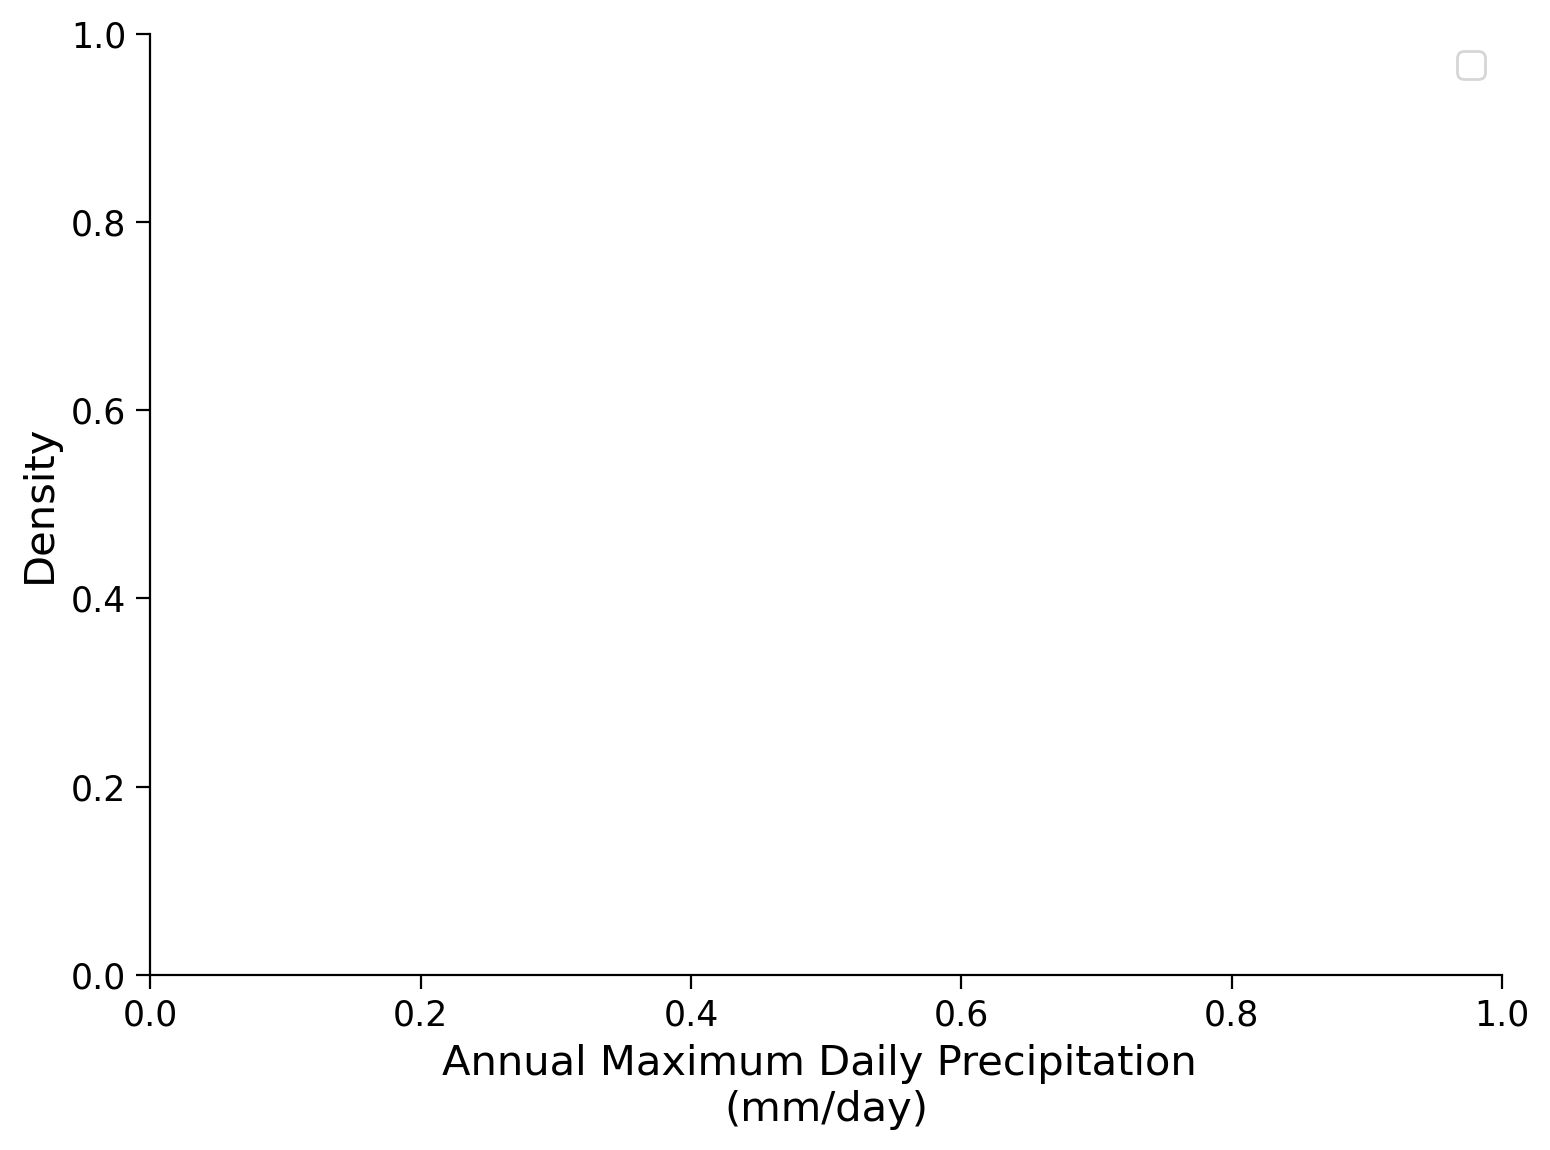

In [ ]:
# set range of shape values to use
range_shape = np.arange(-0.4,0.4+0.1,0.1)

# set scale parameter
scale = 7

# set location parameter
loc = 26

# setup plots
fig, ax = plt.subplots()

# setup colors to use for lines
colors_shape = plt.cm.coolwarm(np.linspace(0,1,range_shape.size))

# generate pdf for each shape value
for idx,shapei in enumerate(range_shape):
    ...

# aesthetics
ax.legend()
ax.set_xlabel('Annual Maximum Daily Precipitation \n(mm/day)')
ax.set_ylabel('Density')

Text(0, 0.5, 'Density')

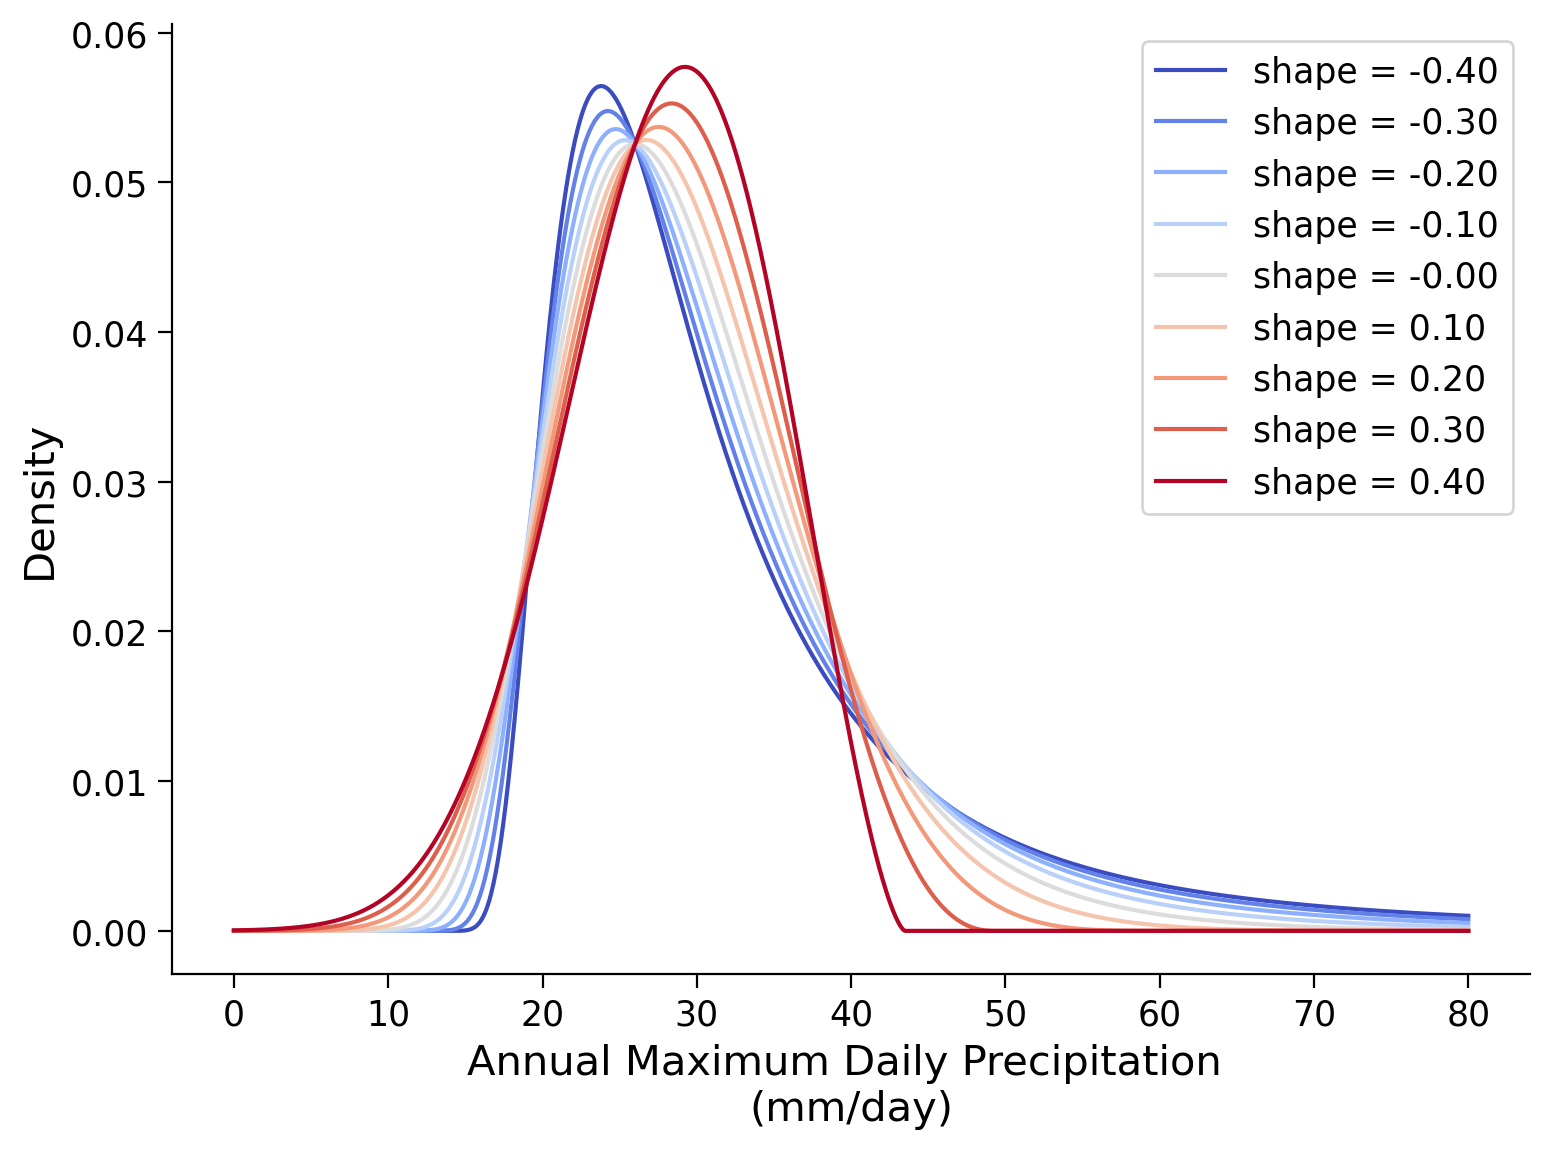

In [16]:
# to_remove solution

# set range of shape values to use
range_shape = np.arange(-0.4,0.4+0.1,0.1)

# set scale parameter
scale = 7

# set location parameter
loc = 26

# setup plots
fig, ax = plt.subplots()

# setup colors to use for lines
colors_shape = plt.cm.coolwarm(np.linspace(0,1,range_shape.size))

# generate pdf for each shape value
for idx,shapei in enumerate(range_shape):
    ax.plot(x_r80,gev.pdf(x_r80, shapei, loc=loc, scale=scale),color=colors_shape[idx],label='shape = %.2f' % shapei)

# aesthetics
ax.legend()
ax.set_xlabel('Annual Maximum Daily Precipitation \n(mm/day)')
ax.set_ylabel('Density')

## **Questions 1**

1. How do the three parameters impact the shape of the distribution? What can you think of how these parameters affect extreme events?**

In [ ]:
# to_remove explanation
"""
The three parameters of the Generalized Extreme Value (GEV) distribution—location, scale, and shape—each impact the shape of the distribution in unique ways:

Location parameter: This parameter shifts the distribution along the x-axis. In the context of extreme events, changing the location parameter shifts the entire distribution of extreme values, affecting the threshold at which extreme events are defined. For example, increasing the location parameter would imply that previoously already extreme events are occurring at higher values.

Scale parameter: The scale parameter influences the spread or width of the distribution. A higher scale parameter will widen the distribution, implying greater variability in the data and thicker tails, while a lower scale parameter will narrow the distribution, implying less probability of extreme events.

Shape parameter: This parameter is unique to the GEV distribution and impacts the tails of the distribution. It can make the tails of the distribution thinner or thicker, which in turn affects the skewness and kurtosis of the distribution. In the context of extreme events, a positive shape parameter results in a heavy-tailed distribution, implying a higher probability of very extreme events (far from the median), while a negative shape parameter results in a light-tailed distribution, implying a lower probability of such events.
""";

# **Summary**
In this tutorial, you explored the the Generalized Extreme Value (GEV) distribution suitable for climate variables containing higher probabilities of extreme events. You used scipy to estimate these parameters from our data and fit a GEV distribution. You compared the fit of the normal and GEV distributions to your data using Quantile-Quantile (QQ) plots and overlaid the probability density functions of both distributions for visual comparison. Finally, you manipulated the parameters of the GEV distribution to understand their effects on the shape of the distribution.

# **Resources**

Data from this tutorial uses the 0.25 degree precipitation dataset E-OBS. It combines precipitation observations to generate a gridded (i.e. no "holes") precipitation over Europe. We used the precipitation data from the gridpoint at 51 N, 6 E. 

The dataset can be accessed using the KNMI Climate Explorer [here](https://climexp.knmi.nl/select.cgi?id=someone@somewhere&field=ensembles_025_rr). The Climate Explorer is a great resource to access, manipulate and visualize climate data, including observations and climate model simulations. It is freely accessible - feel free to explore!